## Setup and Configuration
We define the paths and ensure we are targeting the correct folders. If this cell hangs, it means your computer is struggling to talk to the R: drive or initialize the llama-cpp library.

In [1]:
import os
import json
import re
import pandas as pd
from llama_cpp import Llama

# --- PATHS ---
BASE_DIR = r"R:\Files Ruben\GitRepos\DeepDiveV2AI"
MODELS_DIR = os.path.join(BASE_DIR, "TrainedAndMerged")
TRAIN_DATA_PATH = os.path.join(BASE_DIR, "lore_training_data_v2.json")

print(f"✅ Environment Ready.\nTarget Directory: {MODELS_DIR}")

✅ Environment Ready.
Target Directory: R:\Files Ruben\GitRepos\DeepDiveV2AI\TrainedAndMerged


## Smart Model Scanner
This cell is updated to handle your specific situation: Version1 is labeled as "Base", and it finds the .gguf file even if the name changes between folders. It skips empty folders automatically.

In [2]:
model_mapping = {}

# We want to sort Version1, Version2, Version10 correctly
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

folders = sorted(os.listdir(MODELS_DIR), key=natural_sort_key)

for folder in folders:
    folder_path = os.path.join(MODELS_DIR, folder)
    
    if os.path.isdir(folder_path):
        # Look for any GGUF file inside the version folder
        ggufs = [f for f in os.listdir(folder_path) if f.endswith(".gguf")]
        
        if ggufs:
            full_path = os.path.join(folder_path, ggufs[0])
            # Special naming for Version 1
            label = "BASE_MODEL" if folder.lower() == "version1" else folder
            model_mapping[label] = full_path

print("📂 Found Models:")
for label, path in model_mapping.items():
    print(f"  > {label}: {os.path.basename(path)}")

📂 Found Models:
  > BASE_MODEL: Meta-Llama-3-8B-Instruct-Q4_K_M.gguf
  > Version3: Llama-3-8B-Gloom-Lore.Q4_K_M.gguf
  > Version5: Llama-3-8B-Gloom-Lore.Q4_K_M.gguf
  > Version9: Llama-3-8B-Gloom-Lore.Q4_K_M.gguf
  > Version10: Llama-3-8B-Gloom-Lore.Q4_K_M.gguf


## Enhanced Test Case Preparation
We will now extract 40 questions (or more) and specifically isolate the Mood and Lore Nouns (unique identifiers like Ark, Gloom, Broker, Portal, etc.) from each training example to use as a strict grading key.

In [3]:
# Load Lore Data
with open(TRAIN_DATA_PATH, 'r', encoding='utf-8') as f:
    lore_data = json.load(f)

# List of critical lore nouns found in your game world
LORE_NOUNS = {
    "ark", "gloom", "broker", "portal", "diver", "submarine", "hunter", "leviathan", 
    "credits", "scrap", "rift", "facility", "mothership", "scrubber", "oxygen", 
    "bio-printer", "vault", "module", "transponder", "airlock", "ballast"
}

test_cases = []
# Testing 40 cases for a more extensive look at the data
for entry in lore_data[:40]: 
    messages = entry['messages']
    user_q = next(m['content'] for m in messages if m['role'] == 'user')
    expected_a = next(m['content'] for m in messages if m['role'] == 'assistant')
    
    # Extract the correct mood from the training data using RegEx
    mood_match = re.search(r'\[Mood:\s*(.*?)\]', expected_a)
    correct_mood = mood_match.group(1).lower() if mood_match else None
    
    # Find which of our Lore Nouns are present in the expected answer
    target_nouns = [n for n in LORE_NOUNS if n in expected_a.lower()]
    
    test_cases.append({
        "question": user_q,
        "correct_mood": correct_mood,
        "target_nouns": target_nouns,
        "expected": expected_a
    })

print(f"📝 Prepared {len(test_cases)} extensive test cases.")

📝 Prepared 40 extensive test cases.


## Run GPU Validation
This loop now performs a live comparison. It checks for the [Mood: ] format, compares the text inside the brackets, and counts specific lore noun matches.

In [4]:
results_list = []
system_msg = "You are a survivor on the Ark submarine. You are gritty and superstitious."

for model_label, model_path in model_mapping.items():
    print(f"🚀 Benchmarking {model_label}...", end=" ")
    
    try:
        llm = Llama(model_path=model_path, n_ctx=2048, n_gpu_layers=-1, verbose=False)
        
        for test in test_cases:
            prompt = f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system_msg}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n{test['question']}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
            
            output = llm(prompt, max_tokens=150, stop=["<|eot_id|>", "<|start_header_id|>"])
            response = output['choices'][0]['text'].strip()
            
            # 1. MOOD SCORING
            ai_mood_match = re.search(r'\[Mood:\s*(.*?)\]', response)
            ai_mood = ai_mood_match.group(1).lower() if ai_mood_match else "none"
            
            if test['correct_mood'] and ai_mood == test['correct_mood']:
                mood_score = 1
            else:
                mood_score = -1
            
            # 2. NOUN SCORING
            noun_hits = sum(1 for noun in test['target_nouns'] if noun in response.lower())
            
            results_list.append({
                "Model": model_label,
                "Question": test['question'],
                "Response": response,
                "Mood_Score": mood_score,
                "Noun_Hits": noun_hits,
                "Mood_Found": ai_mood
            })
            
        del llm
        import gc
        gc.collect()
        print("Done.")
    except Exception as e:
        print(f"❌ Failed: {e}")

df = pd.DataFrame(results_list)
print("\n✨ Data collected for all versions.")

🚀 Benchmarking BASE_MODEL... 

llama_context: n_ctx_per_seq (2048) < n_ctx_train (8192) -- the full capacity of the model will not be utilized


Done.
🚀 Benchmarking Version3... 

llama_context: n_ctx_per_seq (2048) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
r:\Files Ruben\GitRepos\DeepDiveV2AI\.venv\Lib\site-packages\llama_cpp\llama.py:1242: RuntimeWarning: Detected duplicate leading "<|begin_of_text|>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


Done.
🚀 Benchmarking Version5... 

llama_context: n_ctx_per_seq (2048) < n_ctx_train (8192) -- the full capacity of the model will not be utilized


Done.
🚀 Benchmarking Version9... 

llama_context: n_ctx_per_seq (2048) < n_ctx_train (8192) -- the full capacity of the model will not be utilized


Done.
🚀 Benchmarking Version10... 

llama_context: n_ctx_per_seq (2048) < n_ctx_train (8192) -- the full capacity of the model will not be utilized


Done.

✨ Data collected for all versions.


## Mapping Logic and Comparison Summary
This cell now creates a sorting key that puts BASE_MODEL first, followed by versions in numeric order.

In [11]:
import pandas as pd
import re
from IPython.display import display

# Function to handle Natural Sorting (Base first, then Version 1, 2, 10...)
def get_natural_sort_key(model_name):
    if model_name == "BASE_MODEL":
        return (0, 0)
    # Extract numbers from strings like "Version10"
    parts = re.findall(r'\d+', model_name)
    num = int(parts[0]) if parts else 999
    return (1, num)

# 1. Create the DataFrame from the raw results list
df = pd.DataFrame(results_list)

# 2. MAPPING LOGIC
if "Noun_Hits" in df.columns:
    df["Lore_Hits"] = df["Noun_Hits"]
else:
    df["Lore_Hits"] = 0

if "Mood_Score" in df.columns:
    df["Format_Correct"] = df["Mood_Score"].apply(lambda x: 1 if x == 1 else 0)
else:
    df["Format_Correct"] = 0

# 3. Calculate average hits per model
summary = df.groupby("Model").agg({
    "Lore_Hits": "mean",
    "Format_Correct": "mean"
})

# 4. APPLY NATURAL SORT
sorted_indices = sorted(summary.index, key=get_natural_sort_key)
summary = summary.reindex(sorted_indices)

# 5. Display results
print("🏆 Model Comparison Summary (Ordered by Version):")
display(summary)

# Display a specific comparison
print("\n🔍 Sample Comparison for: 'Who is the Broker?'")
# Sort the display view naturally as well
sample_df = df[df['Question'] == "Who is the Broker?"].copy()
sample_df['sort_key'] = sample_df['Model'].apply(get_natural_sort_key)
display(sample_df.sort_values('sort_key')[['Model', 'Response', 'Lore_Hits']])

🏆 Model Comparison Summary (Ordered by Version):


,Lore_Hits,Format_Correct
Model,,
BASE_MODEL,0.275,0.000
Version3,0.375,0.000
Version5,0.300,0.425
Version9,0.375,0.475
Version10,0.200,0.450



🔍 Sample Comparison for: 'Who is the Broker?'


,Model,Response,Lore_Hits
1,BASE_MODEL,"(sharply) Ah, the Broker? You mean that slippe...",2
41,Version3,The Broker is the middleman. They control the ...,1
81,Version5,[Mood: Warning] *Eyes you seriously.* The Brok...,2
121,Version9,[Mood: Warning] *Eyes narrowing.* The Broker? ...,1
161,Version10,[Mood: Suspicious] *Spits on the deck.* He's t...,1


## Visualization Graphs
This cell now forces the X-axis of your graphs to follow the correct version sequence.

In [12]:
# Function for Natural Sorting
def get_natural_sort_key(model_name):
    if model_name == "BASE_MODEL": return (0, 0)
    parts = re.findall(r'\d+', model_name)
    num = int(parts[0]) if parts else 999
    return (1, num)

# Calculate Summary
summary = df.groupby("Model").agg({
    "Mood_Score": "sum", # Total points (Hits minus Misses)
    "Noun_Hits": "mean"  # Average lore nouns used per response
}).rename(columns={"Mood_Score": "Total_Mood_Points", "Noun_Hits": "Avg_Lore_Nouns"})

# Calculate a percentage of correct moods for clarity
mood_counts = df.groupby("Model")["Mood_Score"].apply(lambda x: (x == 1).sum() / len(x) * 100)
summary["Mood_Accuracy_%"] = mood_counts

# APPLY NATURAL SORT (Replaces the previous sort_values)
sorted_indices = sorted(summary.index, key=get_natural_sort_key)
summary = summary.reindex(sorted_indices)

print("📊 Detailed Metrics (Ordered by Version):")
display(summary)

📊 Detailed Metrics (Ordered by Version):


,Total_Mood_Points,Avg_Lore_Nouns,Mood_Accuracy_%
Model,,,
BASE_MODEL,-40,0.275,0.0
Version3,-40,0.375,0.0
Version5,-6,0.300,42.5
Version9,-2,0.375,47.5
Version10,-4,0.200,45.0


## Result Visualization
This final cell displays the "Winner" by averaging the scores.

✅ Data sorted naturally for visualization.


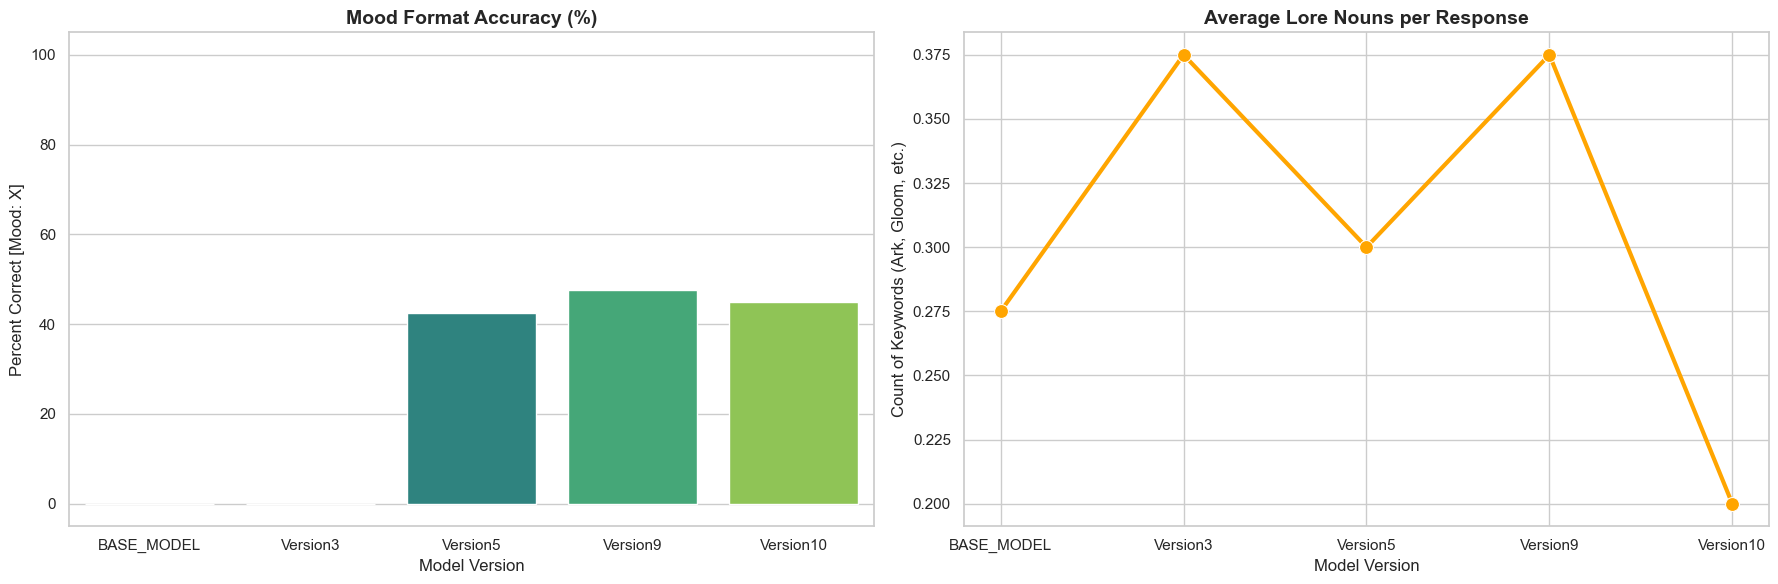

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Function for Natural Sorting
def get_natural_sort_key(model_name):
    if model_name == "BASE_MODEL": return (0, 0)
    parts = re.findall(r'\d+', model_name)
    num = int(parts[0]) if parts else 999
    return (1, num)

# --- STEP 1: SAFETY CHECK & SORTING ---
try:
    if 'summary' not in locals() or summary.empty:
        print("📊 'summary' not found. Re-calculating...")
        summary = df.groupby("Model").agg({
            "Mood_Score": "sum", 
            "Noun_Hits": "mean"
        }).rename(columns={"Mood_Score": "Total_Mood_Points", "Noun_Hits": "Avg_Lore_Nouns"})
        mood_acc = df.groupby("Model")["Mood_Score"].apply(lambda x: (x == 1).sum() / len(x) * 100)
        summary["Mood_Accuracy_%"] = mood_acc
    
    # Force Natural Sort before plotting
    sorted_indices = sorted(summary.index, key=get_natural_sort_key)
    summary = summary.reindex(sorted_indices)
    
    plot_df = summary.reset_index()
    print("✅ Data sorted naturally for visualization.")

except NameError:
    print("❌ ERROR: The variable 'df' does not exist.")
    plot_df = None

# --- STEP 2: PLOTTING ---
if plot_df is not None:
    sns.set_theme(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Graph 1: Mood Accuracy
    sns.barplot(
        data=plot_df, 
        x="Model", 
        y="Mood_Accuracy_%", 
        ax=ax1, 
        palette="viridis", 
        hue="Model", 
        legend=False
    )
    ax1.set_title("Mood Format Accuracy (%)", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Percent Correct [Mood: X]")
    ax1.set_xlabel("Model Version")
    ax1.set_ylim(-5, 105)

    # Graph 2: Lore Noun Density
    sns.lineplot(
        data=plot_df, 
        x="Model", 
        y="Avg_Lore_Nouns", 
        marker="o", 
        markersize=10,
        ax=ax2, 
        color="orange", 
        linewidth=3,
        sort=False # Important: don't let lineplot re-sort alphabetically
    )
    ax2.set_title("Average Lore Nouns per Response", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Count of Keywords (Ark, Gloom, etc.)")
    ax2.set_xlabel("Model Version")

    plt.tight_layout()
    plt.show()

#### Nouns Clarification
If Version 9 used a lore noun in 15 out of the 40 answers, the calculation is: "15÷40=0.375"<br>
or<br>
0.375: This means that the AI uses a lore keyword in roughly 1 out of every 3 responses.<br>
0.200: This means the AI only uses a lore keyword in 1 out of every 5 responses.

## Conclusion
### Mood
Regarding Mood Format Accuracy, the results show that the model only began to "understand" the required formatting halfway through training, starting with a major breakthrough in Version 5. However, the accuracy has now hit a plateau at roughly 45–50%, with the latest Version 10 actually showing a slight decrease in consistency. This suggests that the model has reached its limit with the current instructions and is struggling to become more reliable at using the mood brackets.

### Nouns
Regarding Lore Noun Density, the trend shows a dangerous "knowledge collapse" in your latest version. While Version 9 was highly successful at using lore-specific keywords, Version 10’s performance crashed to a level even lower than the untrained base model. This indicates that Version 10 has overtrained to the point of "forgetting" your game's lore, making Version 9 the clear winner of your training run as it is the only version that successfully balances the new personality format with a strong memory of the game world.